In [18]:
import pandas as pd
from datetime import date
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import sklearn.model_selection 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score 
import sklearn.linear_model 
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dropout
from keras import regularizers

df = pd.read_json('https://raw.githubusercontent.com/vikaswadhwa-dgtl-factory/data_science_challenges/master/03%20-%20User%20History/data/attributes.json')
# constant vaiables 
ROWS  = len(df)
COLUMNS = len(df.columns)

# IDA 
# convert strings of dates into a comma seprated list
for i in range(ROWS):
  df.at[i,'signup_date'] = df.at[i,'signup_date'].split('-')
  df.at[i,'last_trip_date'] = df.at[i,'last_trip_date'].split('-')

# determine date data was pulled
df['pull_date'] = df['signup_date']
for sample in df['pull_date']:
  sample[1] = '07'

# determine whether a user was retained 
def numOfDays(date1,date2):
  firstDate = date(int(date1[0]),int(date1[1]),int(date1[2]))
  secondDate = date(int(date2[0]),int(date2[1]),int(date2[2]))
  return (firstDate - secondDate).days 
df['retained_user'] = np.zeros(ROWS)
df['retained_user'] = df['retained_user'].astype('int8')
for i in range(ROWS):
  date1 = df.at[i,'pull_date']
  date2 = df.at[i,'last_trip_date']
  daysBetween = numOfDays(date1,date2)
  if daysBetween <= 30:
    df.at[i,'retained_user'] = 1
percentRetainded = df['retained_user'].sum()/ROWS
print(percentRetainded)

0.24396


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


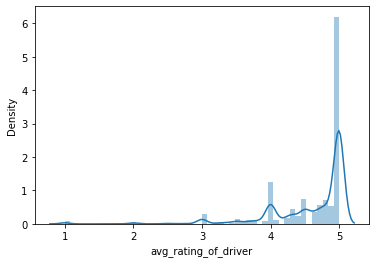

In [19]:
# Distribution plot
sns.distplot(df['avg_rating_of_driver'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


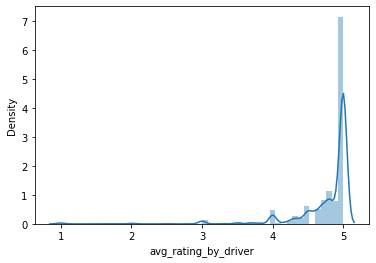

In [20]:
sns.distplot(df['avg_rating_by_driver'])

Text(0, 0.5, 'Counts')

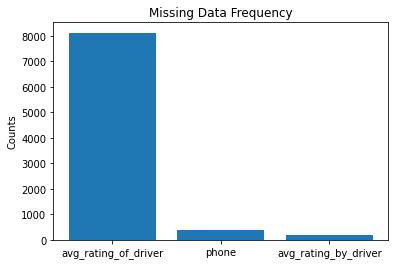

In [21]:
# visualization of missing data
missing_features = df.loc[:,df.isna().sum() > 0]

plt.bar(1 + np.arange(len(missing_features.columns)),height=missing_features.isna().sum().values)
#create ticks on x axis
plt.xticks(1 + np.arange(len(missing_features.columns)),missing_features.columns)
#create title
plt.title('Missing Data Frequency')
#create y label
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

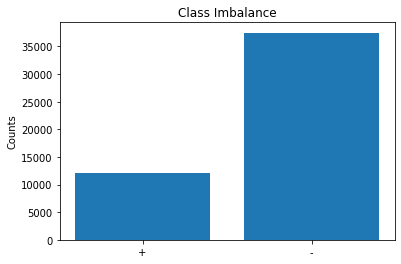

In [22]:
# Based on distribution plots, replace na values with the median value
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())

# remove samples with missing phone data from dataframe
df = df[df['phone'].notna()]

# plot class distribution
missing_features = df.loc[:,df.isna().sum() > 0]
plt.bar([1,2],height=[df['retained_user'].sum(),len(df['retained_user']) - df['retained_user'].sum()])
#create ticks on x axis
plt.xticks([1,2], ['+','-'])
#create title
plt.title('Class Imbalance')
#create y label
plt.ylabel('Counts')


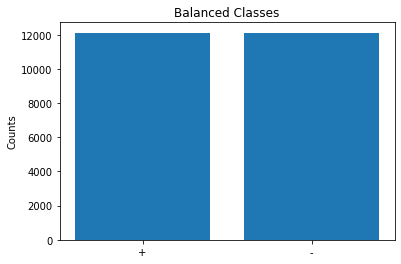

In [23]:
# balance class distribution
class_count_0, class_count_1 = df['retained_user'].value_counts()

# separate samples by class
df_0 = df[df['retained_user'] == 0]
df_1 = df[df['retained_user'] == 1] 
df_0 = df_0.sample(class_count_1)
# cancatenate and randomize samples
df = pd.concat([df_0, df_1], axis=0).sample(frac=1,random_state=1)

 
plt.bar([1,2],height=[df['retained_user'].sum(),len(df['retained_user']) - df['retained_user'].sum()])
#create ticks on x axis
plt.xticks([1,2], ['+','-'])
#create title
plt.title('Balanced Classes')
#create y label
plt.ylabel('Counts')

# seperate input features and target
X = df.copy()
# target
y = X['retained_user']
# 
X.drop(columns = ['retained_user','last_trip_date','signup_date','pull_date'],inplace= True)

In [24]:
# one hot encoding - determine unique cities and phones 
unique_phones = set()
for phone in X['phone']:
  if phone not in unique_phones:
    unique_phones.add(phone)

unique_citys = set()
for city in X['city']:
  if city not in unique_citys:
    unique_citys.add(city)

X["King's Landing"] = X['city'] == "King's Landing"
X['Astapor'] = X['city'] == 'Astapor'
X['Winterfell'] = X['city'] == 'Winterfell'
X['iPhone'] = X['phone'] == 'iPhone'
X['Android'] = X['phone'] == 'Android'
X.drop(columns = ['city','phone'],inplace= True)
X.replace([True, False],[1,0],inplace = True)
# the remaining features can form your X... one hot encode 
X

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,upgraded_user,weekday_pct,avg_dist,avg_rating_by_driver,King's Landing,Astapor,Winterfell,iPhone,Android
28275,3,4.8,1.38,33.3,0,66.7,3.81,4.8,0,1,0,1,0
19398,1,4.9,1.00,0.0,0,100.0,19.71,5.0,0,0,1,1,0
47419,1,5.0,1.00,0.0,1,100.0,16.78,5.0,0,0,1,1,0
45326,2,5.0,1.00,0.0,1,81.3,4.89,4.9,0,0,1,1,0
8140,6,4.4,1.21,33.3,0,38.1,2.33,4.5,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29805,1,4.0,1.00,0.0,0,100.0,31.34,5.0,0,1,0,1,0
21463,0,4.9,1.00,0.0,0,100.0,1.85,5.0,0,0,1,0,1
27397,1,5.0,1.00,0.0,0,100.0,17.48,5.0,1,0,0,0,1
229,2,5.0,1.04,4.9,0,46.3,2.69,4.7,1,0,0,1,0


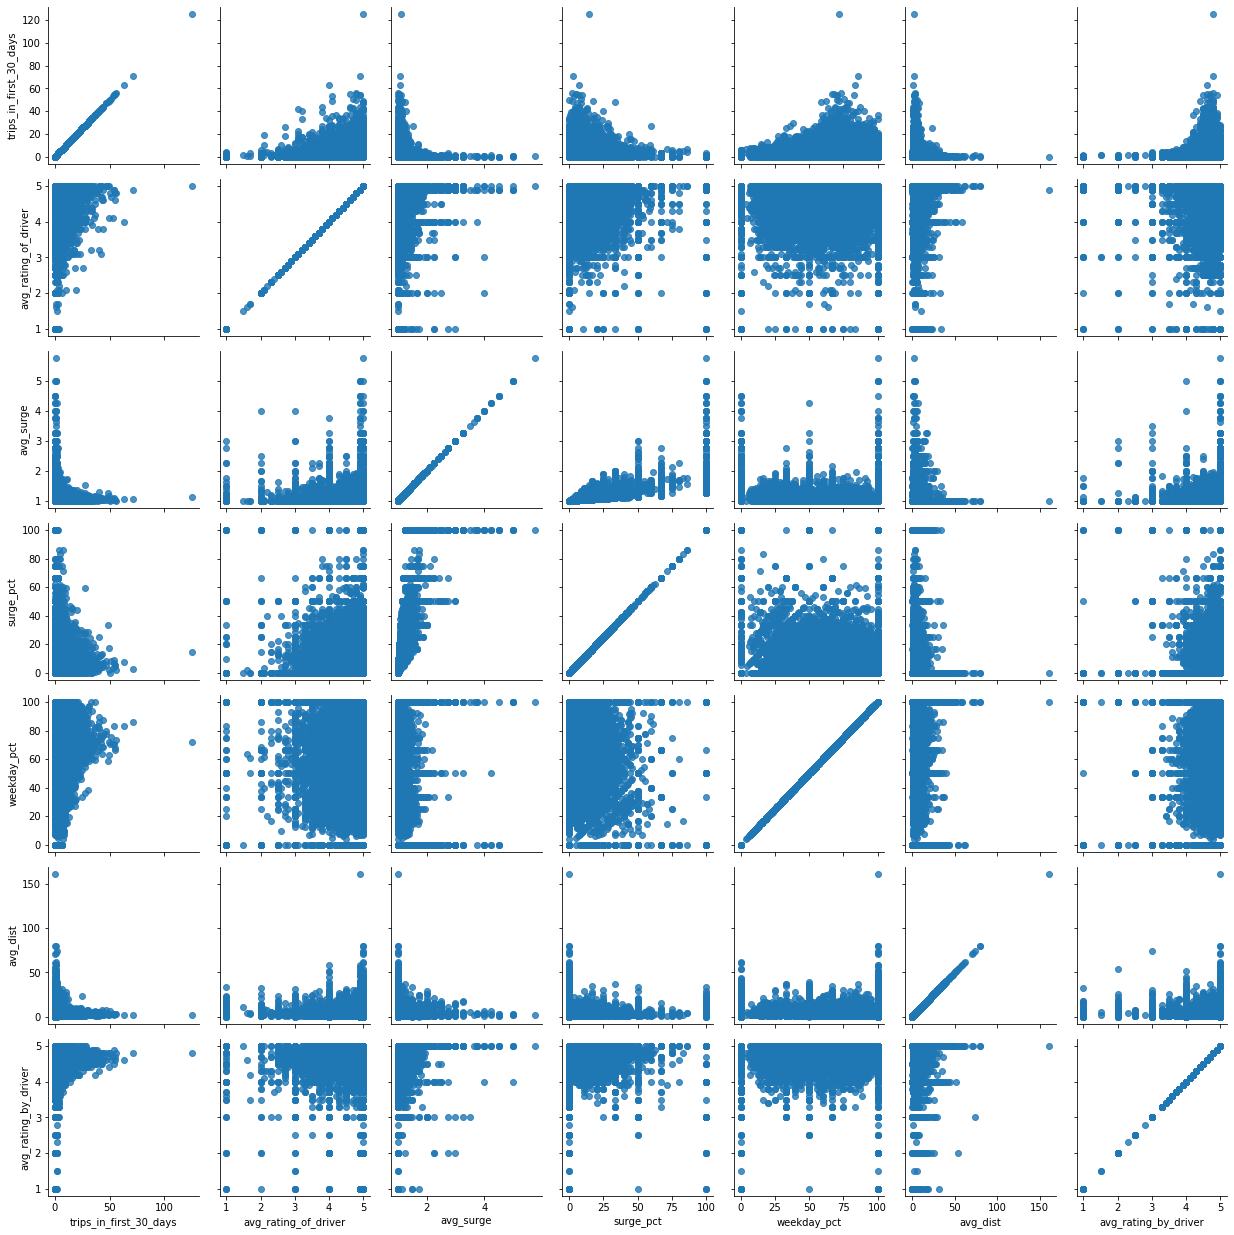

In [25]:
# Scatter plots of continuous features
Continuous = X.copy()
Categorical = Continuous.loc[:,['upgraded_user',"King's Landing", 'Astapor','Winterfell','iPhone','Android']]
Categorical['retained_user'] = y
Continuous.drop(columns = ['upgraded_user',"King's Landing", 'Astapor','Winterfell','iPhone','Android'],inplace= True)

grid=sns.PairGrid(Continuous,palette='RdBu_r')
grid.map(plt.scatter, alpha=0.8)


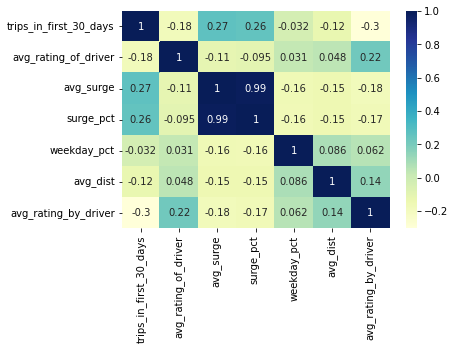

In [26]:
dataplot = sns.heatmap(Continuous.corr(method='spearman'), cmap="YlGnBu", annot=True)


In [27]:
# check if cateogrical features are related to target
pValues = []
for i in range(len(Categorical.columns) - 1):
  contingency = pd.crosstab(Categorical.iloc[:,i], Categorical.iloc[:,-1])
  print(contingency)
  c, p, dof, expected = chi2_contingency(contingency)
  pValues.append(p <= .05)
print(pValues)

retained_user     0     1
upgraded_user            
0              8132  5914
1              3982  6200
retained_user       0     1
King's Landing             
0               10201  8106
1                1913  4008
retained_user     0     1
Astapor                  
0              7651  9435
1              4463  2679
retained_user     0     1
Winterfell               
0              6376  6687
1              5738  5427
retained_user     0      1
iPhone                    
0              4225   1926
1              7889  10188
retained_user     0      1
Android                   
0              7889  10188
1              4225   1926
[True, True, True, True, True, True]


In [28]:
# check if continuous features are related to target
for i in range(len(Continuous.columns)):
  result = pointbiserialr(Continuous.iloc[:,i], Categorical.iloc[:,-1])
  print(result)
# number of trips in first 30 days and avg_dist seem to be correlated with target

PointbiserialrResult(correlation=0.20472921884195794, pvalue=1.4143335927098092e-227)
PointbiserialrResult(correlation=-0.034188528676075976, pvalue=1.0215723368653622e-07)
PointbiserialrResult(correlation=0.0008565967409366055, pvalue=0.8939360462483102)
PointbiserialrResult(correlation=0.02007679630803809, pvalue=0.0017769836555133595)
PointbiserialrResult(correlation=0.016117796951427666, pvalue=0.012113368695321003)
PointbiserialrResult(correlation=-0.11037259253093049, pvalue=1.5368498410565192e-66)
PointbiserialrResult(correlation=-0.02250912899689161, pvalue=0.00045851995073878154)


In [29]:
# To develop a better understanding of the values in each feature, determine max, min, mean, standard deviation
stats = pd.DataFrame([Continuous.max(), Continuous.min(), Continuous.mean(),Continuous.std()],index = ['max','min','mean','std'])
stats



,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
max,125.000000,5.000000,5.750000,100.000000,100.000000,160.960000,5.000000
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
mean,2.734151,4.634151,1.077183,9.099422,60.698287,5.448695,4.770324
std,4.450536,0.562838,0.212979,18.522212,34.379280,5.229296,0.411486


Text(0.5, 1.0, ' Data After Dimensionality Reduction')

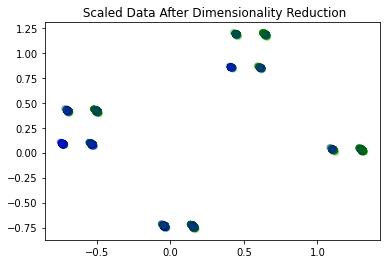

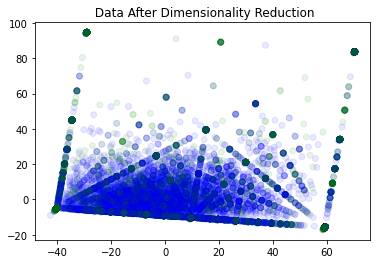

In [30]:
vals_to_scale = X.copy()
#normalization 
norm = MinMaxScaler().fit(vals_to_scale) 
#transform the data 
vals_scaled = norm.transform(vals_to_scale) 
#convert to data frame 
vals_scaled = pd.DataFrame(vals_scaled,index=X.index,columns=X.columns) 

# dimensionality reduction of scaled data
pca_scaled = PCA(n_components=2) 
pca_scaled.fit(vals_scaled) 
vals_2d_scaled = pca_scaled.transform(vals_scaled) 

# dimensionality reduction of unscaled data 
pca = PCA(n_components=2) 
pca.fit(vals_to_scale) 
vals_2d = pca.transform(vals_to_scale) 
colors = y.replace([0,1],['g','b'])
  
plt.figure(1)  
plt.scatter(vals_2d_scaled[:,0],vals_2d_scaled[:,1],c=colors,alpha=0.09) 
plt.title(' Scaled Data After Dimensionality Reduction') 

plt.figure(2) 
plt.scatter(vals_2d[:,0],vals_2d[:,1],c=colors,alpha=0.09) 
plt.title(' Data After Dimensionality Reduction') 


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


Text(0.5, 1.0, 'Visualization of cluster centers')

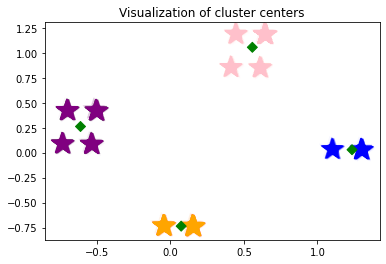

In [31]:
# K-means 
Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(vals_2d_scaled, y, train_size=0.9,random_state=1) 
#initialize cluster centers 
initial = np.array([[.5,1],[-.5,.5],[1.5,0],[0,-.5]] )
kmeans = KMeans(n_clusters = 4, init=initial) 
#fit to training data 
kmeans.fit(Xtrain) 
def getColors(arr):
  result = [] 
  for num in arr: 
      if num == 0: 
          result.append('pink') 
      elif num == 1: 
          result.append('purple') 
      elif num == 2: 
          result.append('blue') 
      else:
          result.append('orange')
  return result
ctrain = getColors(kmeans.labels_)
#Predict cluster 
ypred = kmeans.predict(Xtest) 
ctest = getColors(ypred)
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=ctrain, alpha=0.15) 
plt.scatter(Xtest[:,0],Xtest[:,1],c=ctest,marker='*',s=500,alpha=.02) 
#Cluster centers 
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=[50,50,50,50],marker='D',c='green') 
plt.title('Visualization of cluster centers')

,Accuracy,True Positive Rate,Precision,False Positive Rate,True Negative Rate,False Negative Rate,Prevalence
0,72.8,0.735537,0.713141,0.295136,0.704864,0.264463,0.499381


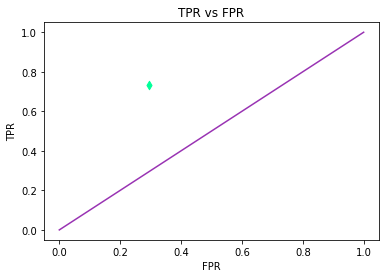

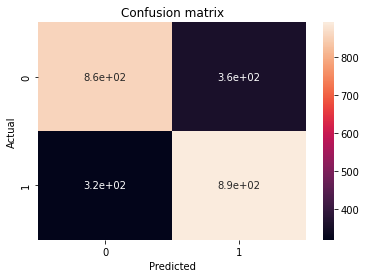

In [33]:
knn = KNeighborsClassifier(n_neighbors=50) 
Accuracy = np.round(100*np.max(cross_val_score(knn, vals_2d_scaled, y, cv=10)),1) 
#fit knn model 
knn = knn.fit(Xtrain,ytrain) 
ypred = knn.predict(Xtest) 
def getMetrics(ypred,ytest):
  # initialize true positive, true negative, false positive, false negative
  TP = FP = TN = FN = 0
  for i in range(len(ypred)): 
      if ypred[i]==1 and ytest.iloc[i]==1: 
          TP+=1 
      elif ypred[i]==1 and ytest.iloc[i]==0: 
          FP+=1 
      elif ypred[i]==0 and ytest.iloc[i]==1: 
          FN+=1 
      elif ypred[i]==0 and ytest.iloc[i]==0: 
          TN+=1 
  #Calculate metrics
  TPR=TP/(TP+FN)  
  Precision=TP/(TP+FP) 
  FPR=FP/(TN+FP)  
  TNR=TN/(TN+FP) 
  FNR=FN/(TP+FN) 
  Prevalence=(TP+FN)/len(ytest) 
  return TPR, Precision, FPR, TNR, FNR, Prevalence

TPR, Precision, FPR, TNR, FNR, Prevalence = getMetrics(ypred,ytest)
c= y.replace([1,0],['b','g'])

plt.figure(1) 
#create points for comparison with TPR and FPR 
x=np.linspace(0,1,100) 
plt.plot(x,x,color=(.6,.2,.7)) 
plt.scatter(FPR,TPR,marker='d',color=(0,1,.6)) 
plt.ylabel('TPR')  
plt.xlabel('FPR') 
plt.title('TPR vs FPR') 
plt.figure(2) 
#display confusion matrix 
confusion_matrix = pd.crosstab(ytest, ypred, rownames=['Actual'], 
colnames=['Predicted']) 
sns.heatmap(confusion_matrix, annot=True) 
plt.title('Confusion matrix')
pd.DataFrame([[Accuracy,TPR, Precision, FPR, TNR, FNR, Prevalence]],columns = ['Accuracy','True Positive Rate','Precision','False Positive Rate','True Negative Rate','False Negative Rate','Prevalence'])


,Accuracy,True Positive Rate,Precision,False Positive Rate,True Negative Rate,False Negative Rate,Prevalence
0,69.5,0.655483,0.695312,0.292256,0.707744,0.344517,0.504333


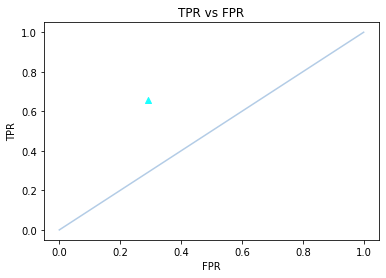

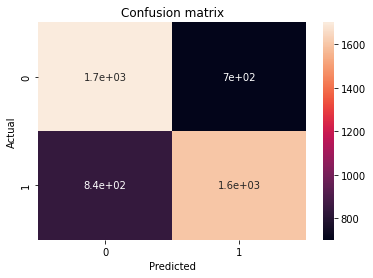

In [35]:
Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(vals_scaled, y, train_size=.8, random_state=1) 
#initialize logistic regresiion classifier 
logistic_regression = sklearn.linear_model.LogisticRegression()  
Accuracy=np.round(100*np.max(cross_val_score(logistic_regression, vals_scaled, y, cv=10)),1) 

#fit model 
model = logistic_regression.fit(Xtrain, ytrain) 
#make predictions 
ypred = model.predict(Xtest) 

# get metrics
TPR, Precision, FPR, TNR, FNR, Prevalence = getMetrics(ypred,ytest)
x=np.linspace(0,1,100)  
plt.figure(1)  
plt.plot(x,x,color=(.7,.8,.9)) 
plt.scatter(FPR,TPR,marker='^',color=(.1,1,1)) 
plt.ylabel('TPR') 
plt.xlabel('FPR') 
plt.title('TPR vs FPR') 
plt.figure(2) 
confusion_matrix = pd.crosstab(ytest, ypred, rownames=['Actual'], colnames=['Predicted']) 
sns.heatmap(confusion_matrix, annot=True) 
plt.title('Confusion matrix')
pd.DataFrame([[Accuracy,TPR, Precision, FPR, TNR, FNR, Prevalence]],columns = ['Accuracy','True Positive Rate','Precision','False Positive Rate','True Negative Rate','False Negative Rate','Prevalence'])


In [36]:
# get training, validation, test data
x_val = vals_scaled[:4000]
x_test = vals_scaled[4000:8000]
x_train = vals_scaled[8000:]

y_val = y[:4000]
y_test = y[4000:8000]
y_train = y[8000:]
# create model
network = models.Sequential()
network.add(layers.Dense(16, activation='relu', input_shape=(13,)))
network.add(layers.Dense(16, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

network.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = network.fit(x_train,
                    y_train,
                    epochs=40,
                    validation_data=(x_val, y_val))



Epoch 1/40
508/508 [==============================] - 2s 2ms/step - loss: 0.6394 - accuracy: 0.6426 - val_loss: 0.6146 - val_accuracy: 0.6737
Epoch 2/40
508/508 [==============================] - 1s 2ms/step - loss: 0.6164 - accuracy: 0.6635 - val_loss: 0.6021 - val_accuracy: 0.6837
Epoch 3/40
508/508 [==============================] - 1s 2ms/step - loss: 0.6019 - accuracy: 0.6822 - val_loss: 0.5881 - val_accuracy: 0.7025
Epoch 4/40
508/508 [==============================] - 1s 2ms/step - loss: 0.5875 - accuracy: 0.6978 - val_loss: 0.5777 - val_accuracy: 0.7007
Epoch 5/40
508/508 [==============================] - 1s 2ms/step - loss: 0.5762 - accuracy: 0.7035 - val_loss: 0.5707 - val_accuracy: 0.7120
Epoch 6/40
508/508 [==============================] - 1s 2ms/step - loss: 0.5699 - accuracy: 0.7067 - val_loss: 0.5710 - val_accuracy: 0.7090
Epoch 7/40
508/508 [==============================] - 1s 2ms/step - loss: 0.5667 - accuracy: 0.7096 - val_loss: 0.5656 - val_accuracy: 0.7160
Epoch 

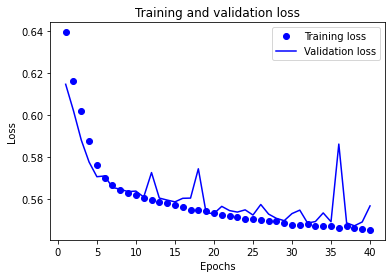

In [37]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

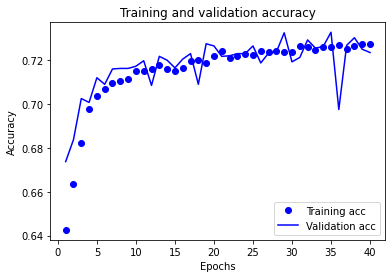

In [38]:
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

125/125 [==============================] - 0s 1ms/step - loss: 0.5778 - accuracy: 0.7013


,Accuracy,True Positive Rate,Precision,False Positive Rate,True Negative Rate,False Negative Rate,Prevalence
0,0.70125,0.808414,0.661277,0.403059,0.596941,0.191586,0.49325


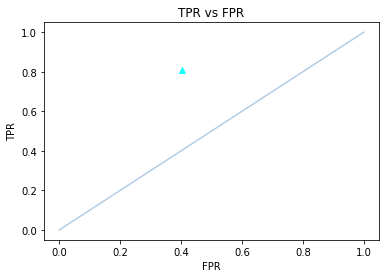

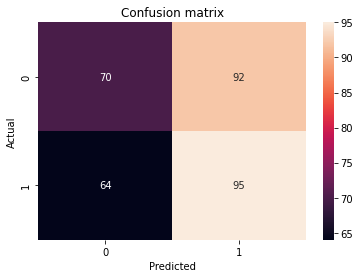

In [39]:
# result for neural network without regularization
results = network.evaluate(x_test, y_test)
ypred = pd.Series( (network.predict(x_test) >= .5).reshape(len(y_test))).replace([True,False],[1,0])
TPR, Precision, FPR, TNR, FNR, Prevalence = getMetrics(ypred,y_test)
x=np.linspace(0,1,100)  
plt.figure(1)  
plt.plot(x,x,color=(.7,.8,.9)) 
plt.scatter(FPR,TPR,marker='^',color=(.1,1,1)) 
plt.ylabel('TPR') 
plt.xlabel('FPR') 
plt.title('TPR vs FPR') 
plt.figure(2) 
confusion_matrix = pd.crosstab(y_test, ypred, rownames=['Actual'], colnames=['Predicted']) 
sns.heatmap(confusion_matrix, annot=True) 
plt.title('Confusion matrix')
pd.DataFrame([[results[1],TPR, Precision, FPR, TNR, FNR, Prevalence]],columns = ['Accuracy','True Positive Rate','Precision','False Positive Rate','True Negative Rate','False Negative Rate','Prevalence'])

In [40]:
# Dropout regularization

network = models.Sequential()
network.add(layers.Dense(16, activation='relu', input_shape=(13,)))
network.add(Dropout(0.2))
network.add(layers.Dense(16, activation='relu'))
network.add(Dropout(0.2))
network.add(layers.Dense(1, activation='sigmoid'))

network.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = network.fit(x_train,
                    y_train,
                    epochs=40,
                    validation_data=(x_val, y_val))


Epoch 1/40
508/508 [==============================] - 2s 2ms/step - loss: 0.6599 - accuracy: 0.6032 - val_loss: 0.6228 - val_accuracy: 0.6765
Epoch 2/40
508/508 [==============================] - 1s 2ms/step - loss: 0.6351 - accuracy: 0.6444 - val_loss: 0.6139 - val_accuracy: 0.6885
Epoch 3/40
508/508 [==============================] - 2s 4ms/step - loss: 0.6273 - accuracy: 0.6641 - val_loss: 0.6044 - val_accuracy: 0.6982
Epoch 4/40
508/508 [==============================] - 2s 4ms/step - loss: 0.6146 - accuracy: 0.6771 - val_loss: 0.5944 - val_accuracy: 0.7028
Epoch 5/40
508/508 [==============================] - 2s 3ms/step - loss: 0.6065 - accuracy: 0.6816 - val_loss: 0.5829 - val_accuracy: 0.7075
Epoch 6/40
508/508 [==============================] - 1s 2ms/step - loss: 0.5987 - accuracy: 0.6891 - val_loss: 0.5754 - val_accuracy: 0.7130
Epoch 7/40
508/508 [==============================] - 1s 2ms/step - loss: 0.5911 - accuracy: 0.6945 - val_loss: 0.5688 - val_accuracy: 0.7147
Epoch 

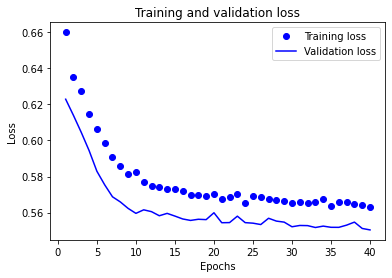

In [41]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

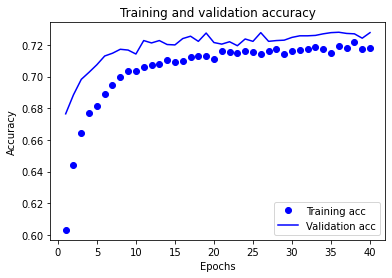

In [42]:
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

125/125 [==============================] - 0s 1ms/step - loss: 0.5713 - accuracy: 0.7048


,Accuracy,True Positive Rate,Precision,False Positive Rate,True Negative Rate,False Negative Rate,Prevalence
0,0.70475,0.696401,0.702454,0.287124,0.712876,0.303599,0.49325


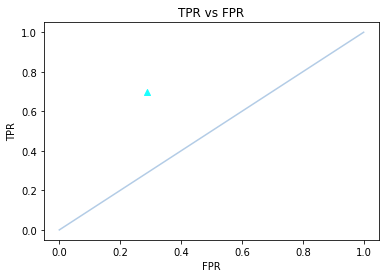

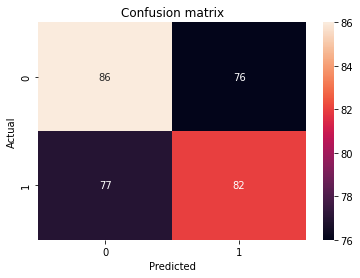

In [43]:
# result for neural network with dropout regularization
results = network.evaluate(x_test, y_test)
ypred = pd.Series( (network.predict(x_test) >= .5).reshape(len(y_test))).replace([True,False],[1,0])
TPR, Precision, FPR, TNR, FNR, Prevalence = getMetrics(ypred,y_test)
x=np.linspace(0,1,100)  
plt.figure(1)  
plt.plot(x,x,color=(.7,.8,.9)) 
plt.scatter(FPR,TPR,marker='^',color=(.1,1,1)) 
plt.ylabel('TPR') 
plt.xlabel('FPR') 
plt.title('TPR vs FPR') 
plt.figure(2) 
confusion_matrix = pd.crosstab(y_test, ypred, rownames=['Actual'], colnames=['Predicted']) 
sns.heatmap(confusion_matrix, annot=True) 
plt.title('Confusion matrix')
pd.DataFrame([[results[1],TPR, Precision, FPR, TNR, FNR, Prevalence]],columns = ['Accuracy','True Positive Rate','Precision','False Positive Rate','True Negative Rate','False Negative Rate','Prevalence'])

In [44]:
# L1 + L2 regularization
network = models.Sequential()
network.add(layers.Dense(16, activation='relu', input_shape=(13,)))
network.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
network.add(layers.Dense(1, activation='sigmoid'))

network.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = network.fit(x_train,
                    y_train,
                    epochs=40,
                    validation_data=(x_val, y_val))

Epoch 1/40
508/508 [==============================] - 2s 2ms/step - loss: 0.6379 - accuracy: 0.6516 - val_loss: 0.6138 - val_accuracy: 0.6712
Epoch 2/40
508/508 [==============================] - 1s 2ms/step - loss: 0.6177 - accuracy: 0.6768 - val_loss: 0.6037 - val_accuracy: 0.6860
Epoch 3/40
508/508 [==============================] - 1s 2ms/step - loss: 0.6054 - accuracy: 0.6844 - val_loss: 0.5894 - val_accuracy: 0.7013
Epoch 4/40
508/508 [==============================] - 1s 2ms/step - loss: 0.5920 - accuracy: 0.6916 - val_loss: 0.5820 - val_accuracy: 0.7060
Epoch 5/40
508/508 [==============================] - 1s 2ms/step - loss: 0.5804 - accuracy: 0.7000 - val_loss: 0.5709 - val_accuracy: 0.7150
Epoch 6/40
508/508 [==============================] - 1s 2ms/step - loss: 0.5719 - accuracy: 0.7064 - val_loss: 0.5670 - val_accuracy: 0.7182
Epoch 7/40
508/508 [==============================] - 1s 2ms/step - loss: 0.5669 - accuracy: 0.7105 - val_loss: 0.5635 - val_accuracy: 0.7182
Epoch 

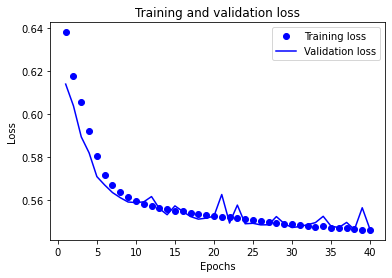

In [45]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

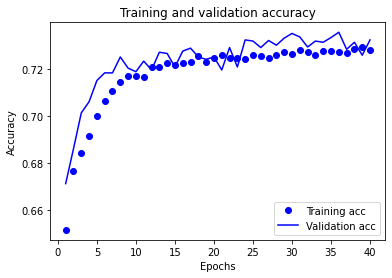

In [46]:
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

125/125 [==============================] - 0s 1ms/step - loss: 0.5687 - accuracy: 0.7088


,Accuracy,True Positive Rate,Precision,False Positive Rate,True Negative Rate,False Negative Rate,Prevalence
0,0.70875,0.732894,0.693858,0.314751,0.685249,0.267106,0.49325


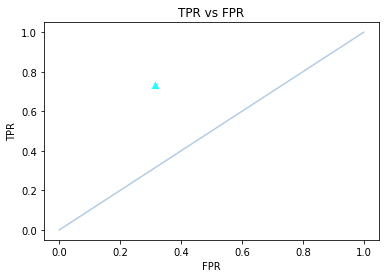

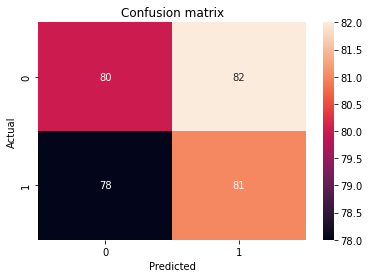

In [47]:
# result for neural network with L1 + L2 regularization
results = network.evaluate(x_test, y_test)
ypred = pd.Series( (network.predict(x_test) >= .5).reshape(len(y_test))).replace([True,False],[1,0])
TPR, Precision, FPR, TNR, FNR, Prevalence = getMetrics(ypred,y_test)
x=np.linspace(0,1,100)  
plt.figure(1)  
plt.plot(x,x,color=(.7,.8,.9)) 
plt.scatter(FPR,TPR,marker='^',color=(.1,1,1)) 
plt.ylabel('TPR') 
plt.xlabel('FPR') 
plt.title('TPR vs FPR') 
plt.figure(2) 
confusion_matrix = pd.crosstab(y_test, ypred, rownames=['Actual'], colnames=['Predicted']) 
sns.heatmap(confusion_matrix, annot=True) 
plt.title('Confusion matrix')
pd.DataFrame([[results[1],TPR, Precision, FPR, TNR, FNR, Prevalence]],columns = ['Accuracy','True Positive Rate','Precision','False Positive Rate','True Negative Rate','False Negative Rate','Prevalence'])